# 차근차근 딥러닝 Part 05. 딥러닝 분류 - Step 05. 딥러닝 분류 실습

## 0. Torchvision 설치

In [1]:
#!pip install torchvision

## 1. MNIST 데이터 로딩

- 필요한 라이브러리 임포트

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from copy import deepcopy
from sklearn.metrics import confusion_matrix

- 데이터 로딩

In [3]:
# Train 데이터셋 로딩
train_data = datasets.MNIST(
    root='./data', # 데이터셋을 저장할 경로, 이 경우 현재 위치에 data 폴더를 만들고 다운로드 수행
    train=True,  # True이면 Train 데이터셋을 다운로드
    download=True, # True일 경우 다운로드
    transform=transforms.Compose( #어떤 형태로 데이터를 불러올 것인가. 
        [transforms.ToTensor(),]  # 일반 이미지는 0-255사이 값, (H, W, C) 형태
    ),                            # pytorch: 0-1사이의 값을 가지고 (C, H, W)의 형태
)

# Test 데이터셋 로딩
test_data = datasets.MNIST(
    root='./data', 
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(),]
    ),
)

In [4]:
def show_img(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)
    plt.imshow(img, cmap='gray')
    plt.show()

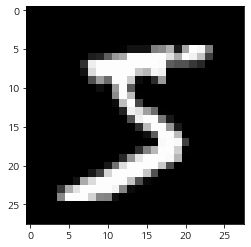

In [5]:
show_img(train_data.data[0]) # Train 데이터넷 1번째 이미지 확인

## 2. 전처리 (Pre-processing)

- 이미지 값을 0 ~ 1 사이의 값으로 변환
- 텐서 크기 변환: (Batch_size, C, H, W) $\to$ (batch_size, H $\times$ W)

In [6]:
def norm_and_resize(img):
    img = img.float() / 255.0 # 0 ~ 255 -> 0 ~ 1사이의 값으로 변환
    img = img.view(img.size(0), -1) # 28 * 28 픽셀 -> 1 * 784 픽셀
    return img

- Train 데이터셋 $\to$ train / valid 데이터셋으로 분할

In [7]:
def make_train_valid_test(ratio, train, test):
    
    ### Split train dataset -> train / valid ###
    
    # Train / valid 데이터셋에 필요한 숫자 계산
    train_cnt = int(train.data.size(0) * ratio[0])
    valid_cnt = int(train.data.size(0) * ratio[1])
    cnts = [train_cnt, valid_cnt]
    
    # Train -> 랜덤추출하여 train / valid 구성
    indices = torch.randperm(train.data.size(0))
    train_x = torch.index_select(train.data, dim=0, index=indices)
    train_y = torch.index_select(train.targets, dim=0, index=indices)
    
    train_x, valid_x = train_x.split(cnts, dim=0)
    train_y, valid_y = train_y.split(cnts, dim=0)
    test_x, test_y = test.data, test.targets
    
    # 데이터 Normalize & (batch_size, H*W)로 텐서크기 변환
    train_x = norm_and_resize(train_x)
    valid_x = norm_and_resize(valid_x)
    test_x =  norm_and_resize(test_x)

    # train, valid, test 데이터셋을 하나로 묶어주기
    x = [train_x, valid_x, test_x]
    y = [train_y, valid_y, test_y]
    
    # train, valid, test 데이터셋 형태를 모니터로 확인
    for x_i, y_i in zip(x, y):
        print(x_i.size(), y_i.size())
        
    # 결괏값을 튜플로 리턴
    return x, y

## 3. DNN 신경망 구축

In [8]:
# 딥러닝 모델 생성 -> Pytorch의 nn.Module 활용
class MyModel(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim # 입력 차원
        self.output_dim = output_dim # 출력 차원
        
        super().__init__() # 부모 클래스 __init__ 보호
        
        # 은닉층(Hidden Layer) 설계
        self.linear1 = nn.Linear(input_dim, 500)
        self.linear2 = nn.Linear(500, 400)
        self.linear3 = nn.Linear(400, 300)
        self.linear4 = nn.Linear(300, 200)
        self.linear5 = nn.Linear(200, 100)
        self.linear6 = nn.Linear(100, 50)
        self.linear7 = nn.Linear(50, output_dim)
        #self.act = nn.ReLU()
        self.act = nn.LeakyReLU() # LeakyReLU 사용
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        
    def forward(self, x):
        
        # 객체 호출 시 입력 텐서 크기: |x| = (batch_size, input_dim)
        h = self.act(self.linear1(x)) # |h| = (batch_size, 32)
        h = self.act(self.linear2(h))
        h = self.act(self.linear3(h))
        h = self.act(self.linear4(h))
        h = self.act(self.linear5(h))
        h = self.act(self.linear6(h))
        y = self.logsoftmax(self.linear7(h))
        # 출력텐서 크기: |y| = (batch_size, output_dim)
        
        # 결괏값 반환(return)
        return y

## 4. DNN 신경망을 이용한 학습(Train) 함수 구현

In [9]:
# 학습 모델 저장을 위한 deepcopy 라이브러리 임포트
from copy import deepcopy

def train(
    model,     # 신경망 모델
    x,         # 학습데이터
    y,         # 예측값(정답)
    crit,      # 손실함수
    lr=1e-4,   # 학습률
    n_epochs=100,  # Epoch 수행 횟수
    batch_size=32, # 미니배치 크기
    print_interval=1000, # 학습결과를 출력하는 간격
    early_stop=100,      # 학습 Loss가 n회 연속 떨어지지 않는 경우 종료
    model_fn='model.pth' # 종료된 학습 파라미터가 저장될 파일 이름
):

    print(model) # Model 구조를 확인하기 위한 출력
    lowest_loss = np.inf # 최소 Loss를 비교하기 위한 초깃값 -> 무한대로 설정
    lowest_epoch = np.inf
    best_model = None
    
    #optimizer = optim.SGD(model.parameters(), lr=lr)
    optimizer = optim.Adam(model.parameters())
    
    # GPU 사용 가능할 경우 사용, 불가능할 경우 CPU 사용
    device = torch.device('cpu')
    if torch.cuda.is_available():
        device = torch.device('cuda')
    
    model = model.to(device)
    x = [x_i.to(device) for x_i in x]
    y = [y_i.to(device) for y_i in y]
    
    ### Epoch ###
    
    # train, valid loss 변경 이력 저장을 위한 리스트 생성
    train_history = []
    valid_history = []
    
    # epoch 시작
    for epoch_index in range(n_epochs):
        
        train_x, train_y = x[0], y[0]
        valid_x, valid_y = x[1], y[1]
        test_x, test_y = x[2], y[2]
        
        # 미니배치 만들기 x[0], y[0] --> train set
        indices= torch.randperm(train_x.size(0), device=train_x.device)
        indices = torch.randperm(train_x.size(0)).to(device)
        
        train_x = torch.index_select(train_x, dim=0, index=indices)
        train_y = torch.index_select(train_y, dim=0, index=indices)
        
        train_x_batch = torch.split(train_x, batch_size, dim=0)
        train_y_batch = torch.split(train_y, batch_size, dim=0)
        
        ### Train 데이터 학습 시작 ###
        model.train() # 학습모드 On
        train_loss = 0
        for x_i, y_i in zip(train_x_batch, train_y_batch):
            
            # 텐서 형태
            # |x_i| = (batch_size, 784), |y_i| = (batch_size, 1)
            
            # 전진(forward) 학습 
            y_hat_i = model(x_i)

            # 손실값 계산
            loss = crit(y_hat_i, y_i.squeeze())

            # 미분 수행 (back propagation)
            optimizer.zero_grad() # 기존 미분값이 있다면 초기화
            loss.backward()
        
            # Stochastic Gradient Descent 수행
            optimizer.step()
            
            # Total Loss 업데이트
            train_loss += float(loss) # 메모리 누수 방지(computation graph 없애기)
        
        # Total train loss -> average train loss
        train_loss /= len(train_x_batch)
        
        ### 최종 Train Loss 계산 -> Train 종료 ###
        
        ### Validation 시작 ###
        model.eval() # 학습모드 off
        with torch.no_grad():
            # valid 데이터셋을 미니배치로 분할
            valid_x_batch = valid_x.split(batch_size, dim=0)
            valid_y_batch = valid_y.split(batch_size, dim=0)
            
            valid_loss = 0
            
            for x_i, y_i in zip(valid_x_batch, valid_y_batch):
                y_hat_i = model(x_i)
                loss = crit(y_hat_i, y_i.squeeze())
                valid_loss += float(loss)

        ### 최종 Valid Loss 계산 -> Validation 종료 ###
        valid_loss = valid_loss / len(valid_x_batch)
        
        # Train, valid loss를 저장
        train_history += [train_loss]
        valid_history += [valid_loss]
        
        # 1회 epoch 종료 후 Loss 출력
        if (epoch_index + 1) % print_interval == 0:
            print(
                'Epoch({0:2d}/{1:2d}): train_loss={2:8.6f}  valid_loss={3:8.6f}  lowest_loss={4:8.6f}'.format(
                    epoch_index+1, 
                    n_epochs,
                    train_loss,
                    valid_loss,
                    lowest_loss,               
                )
            )

        # Valid Loss를 확인하여 최소 Loss일 경우 모델을 저장
        if valid_loss <= lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = epoch_index + 1
            best_model = deepcopy(model.state_dict())
            torch.save(
                {
                    #'model_state_dict': best_model.state_dict(),
                    'model': best_model,
                    'n_epochs': n_epochs,
                    'batch_size': batch_size,
                    'lr': lr,
                    'optimizer': 'SGD',
                }, 
                model_fn
            )
        
        # 지정된 횟수(early_stop) 동안 학습 진전이 없을 경우 조기 종료
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch_index + 1:
                print("There is no improvement during last %d epochs." % early_stop)
                break

    print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
        
    return train_history, valid_history

In [90]:
def visualize_loss_history(train_loss_history, valid_loss_history):
    
    from matplotlib import font_manager, rc
    import matplotlib.pyplot as plt
    
    #한글 폰트 안깨지게 설정
    plt.rcParams['axes.unicode_minus'] = False
    
    # 글꼴(font) 설정
    SMALL_SIZE = 25
    MEDIUM_SIZE = 30
    BIGGER_SIZE = 35 
    plt.rc('font', size=SMALL_SIZE) # 기본 글자 크기
    plt.rc('axes', titlesize=SMALL_SIZE) # sub 그림 제목 글자 크기
    plt.rc('axes', labelsize=MEDIUM_SIZE) # x, y축 글자크기
    plt.rc('xtick', labelsize=SMALL_SIZE) # x축 눈금 크기
    plt.rc('ytick', labelsize=SMALL_SIZE) # y축 눈금 크기
    plt.rc('legend', fontsize=SMALL_SIZE) # 범례 글자 크기
    plt.rc('figure', titlesize=BIGGER_SIZE) # 그림 제목 크기

    # 그리기(Plotting)
    plot_from = 0
    plt.figure(figsize=(20, 10))
    plt.grid(True)
    plt.title("Train / Valid Loss History")
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.plot(
        range(plot_from, len(train_history)), 
        train_history[plot_from:],
        label='Train Histroy',
    )
    plt.plot(
        range(plot_from, len(valid_history)), 
        valid_history[plot_from:],
        label='Valid History',
    )
    
    plt.legend()
    plt.yscale('log')
    plt.show()

## 5. 학습 수행

In [11]:
# 하이퍼 파라미터 설정
params = {
    'batch_size':  128,
    'n_epochs': 1000, 
    'print_interval': 10, 
    'lr': 1e-4, 
    'early_stop': 50,
    'model_fn': 'model_classification.pth', 
}

# Train, Valid, Test 데이터셋 분할
train_valid_ratio = [0.8, 0.2]
x, y = make_train_valid_test(train_valid_ratio, train_data, test_data)

# 모델 객체 생성 -> MyModel 클래스를 이용하여 빈 모델 생성
input_size =x[0].size(-1)
output_size = int(max(y[0])) + 1
model = MyModel(input_size, output_size)

# 손실함수 생성
loss_func=nn.NLLLoss()

# train 함수 호출을 통해 학습 수행
train_history, valid_history = train(model, x, y, loss_func, **params)

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])
MyModel(
  (linear1): Linear(in_features=784, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=400, bias=True)
  (linear3): Linear(in_features=400, out_features=300, bias=True)
  (linear4): Linear(in_features=300, out_features=200, bias=True)
  (linear5): Linear(in_features=200, out_features=100, bias=True)
  (linear6): Linear(in_features=100, out_features=50, bias=True)
  (linear7): Linear(in_features=50, out_features=10, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
  (logsoftmax): LogSoftmax(dim=-1)
)
Epoch(10/1000): train_loss=0.024684  valid_loss=0.120839  lowest_loss=0.093760
Epoch(20/1000): train_loss=0.012531  valid_loss=0.117679  lowest_loss=0.093760
Epoch(30/1000): train_loss=0.013314  valid_loss=0.116059  lowest_loss=0.093760
Epoch(40/1000): train_loss=0.008985  valid_loss=0.119670  lowest_loss=0.093760
Epoc

## 6. 학습 Loss 시각화

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Substituting symbol - from STIXGeneral
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Substituting symbol - from STIXGeneral
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Substituting symbol - from STIXGeneral
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Substituting symbol - from STIXGeneral
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Substituting symbol - from STIXGeneral
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Substituting symbol - from STIXGeneral
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Substituting symbol - from STIXGeneral
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Substituting sy

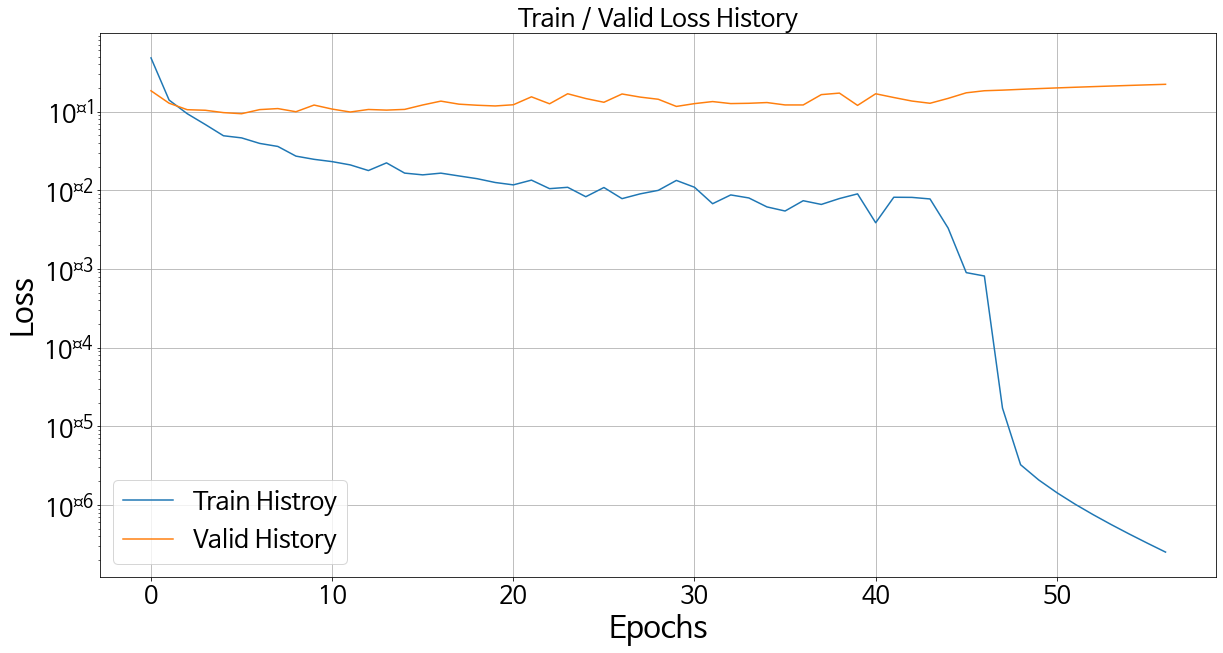

In [91]:
visualize_loss_history(train_history, valid_history)

## 7. 학습 모델 업로드

In [15]:
input_size =x[0].size(-1)
output_size = int(max(y[0])) + 1
model_fn = 'model_classification.pth'

# nn.Module을 상속받은 클래스를 이용하여 빈 모델 생성
model = MyModel(input_size, output_size)

# model.pth 파일 정보를 업로드하여 check_point 변수에 저장
check_point = torch.load(model_fn)

# model.pth에 저장된 학습 파라미터를 model에 업로드
model.load_state_dict(check_point['model'])

<All keys matched successfully>

## 8. 예측 및 평가

### 8.1. 테스트셋 전체를 평가하는 함수

In [92]:
def inference_testset(model, x, y, crit, batch_size=128):
    test_loss = 0
    y_hat = [] # Test 데이터의 예측값을 저장하기 위한 배열
    
    with torch.no_grad():
        test_x = x.split(batch_size, dim=0)
        test_y = y.split(batch_size, dim=0)

        for x_i, y_i in zip(test_x, test_y):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            test_loss += float(loss)
            y_hat += [y_hat_i]
    test_loss /= len(test_x) # 전체 Test Loss
    
    # pytorch를 이용하여 최대값을 갖는 index를 찾기 위해
    # y_hat 리스트를 concatenate하여 tensor로 변환
    y_hat = torch.cat(y_hat, dim=0)
    
    # 최종 예측값 추출
    inference_result = torch.argmax(y_hat, dim=-1)
    
    # 정확도 계산
    correct_count = (inference_result == y).sum()
    accuracy = correct_count / len(y) * 100
    
    print('Test Accuracy: {0:2.2f}%'.format(accuracy))
    print('Test Loss: {0:2.8f}'.format(test_loss))
    
    return inference_result

In [100]:
result = inference_testset(model, x[-1], y[-1], nn.NLLLoss())

# Confusion Matrix를 이용한 시각화
df_confusion_matrix = pd.DataFrame(
    confusion_matrix(y[-1], result),
    index=['true_%d' % i for i in range(10)],
    columns=['pred_%d' % i for i in range(10)]
)
#print(df_confusion_matrix) # Jupyter Notebook 이외 도구를 사용할 경우 활성화
df_confusion_matrix # Jupyter Notebook에서 결과 확인 시

Test Accuracy: 97.80%
Test Loss: 0.08612475


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,967,1,1,0,0,1,7,1,2,0
true_1,0,1126,5,0,0,0,0,1,3,0
true_2,3,0,1009,6,1,1,0,6,6,0
true_3,0,0,4,972,0,14,0,6,5,9
true_4,0,0,5,0,961,0,6,1,0,9
true_5,2,0,0,4,3,875,2,0,4,2
true_6,1,3,1,1,4,5,940,0,3,0
true_7,1,1,10,1,2,0,1,1000,2,10
true_8,3,1,4,4,4,4,0,3,947,4
true_9,0,2,0,0,14,5,0,3,2,983


In [101]:
print(df_confusion_matrix)

        pred_0  pred_1  pred_2  pred_3  pred_4  pred_5  pred_6  pred_7  \
true_0     967       1       1       0       0       1       7       1   
true_1       0    1126       5       0       0       0       0       1   
true_2       3       0    1009       6       1       1       0       6   
true_3       0       0       4     972       0      14       0       6   
true_4       0       0       5       0     961       0       6       1   
true_5       2       0       0       4       3     875       2       0   
true_6       1       3       1       1       4       5     940       0   
true_7       1       1      10       1       2       0       1    1000   
true_8       3       1       4       4       4       4       0       3   
true_9       0       2       0       0      14       5       0       3   

        pred_8  pred_9  
true_0       2       0  
true_1       3       0  
true_2       6       0  
true_3       5       9  
true_4       0       9  
true_5       4       2  
true_6    

### 8.2. 1개 손글씨 이미지를 입력했을 경우 추론하는 함수

In [42]:
def inference(model, img):
    # 입력 이미지 출력
    print('입력 이미지')
    show_img(img)
    
    with torch.no_grad():
        y_hat = model(img)
    
    inference_result = torch.argmax(y_hat, dim=-1)
    
    print(f'예측 결과: {inference_result}')

입력 이미지


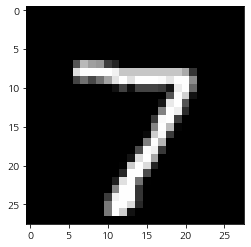

예측 결과: 7


In [43]:
# Test 데이터셋의 첫번째 이미지 예측 결과
inference(model, x[-1][0])

입력 이미지


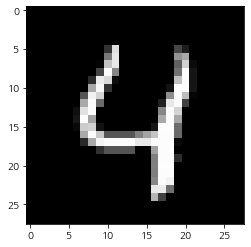

예측 결과: 4


In [44]:
# Test 데이터셋의 5번째 이미지 예측 결과
inference(model, x[-1][4])